In [ ]:
# Before running the sample:
#    pip install --pre azure-ai-projects>=2.0.0b1
#    pip install azure-identity

from azure.identity import DefaultAzureCredential
from azure.ai.projects import AIProjectClient
from azure.identity import DefaultAzureCredential, get_bearer_token_provider

token_provider = get_bearer_token_provider(
    DefaultAzureCredential(), "https://cognitiveservices.azure.com/.default"
)

myEndpoint = "https://aifsweden.services.ai.azure.com/api/projects/AIFSwedenProject01"

project_client = AIProjectClient(
    endpoint=myEndpoint,
    credential=DefaultAzureCredential(),
)

myAgent = "LangAgent2"

# Get an existing agent
agent = project_client.agents.get(agent_name=myAgent)
print(f"Retrieved agent: {agent.name}")

client = project_client.get_openai_client()

# Reference the agent to get a response
response = client.responses.create(
    input=[{"role": "user", "content": """Tell me ALL the PII elements from this story:

The Princess, the King, and the Dragon
In the kingdom of Eldoria, Princess Elara lived in the grand castle at 1 Royal Crescent, Eldoria City. Her official email was elara@eldoria-royals.com—a detail she guarded carefully.
King Aldric, her father, ruled from the same castle but had his own chambers and his own inbox: king.aldric@eldoria-royals.com. He often reminded Elara never to share her address with strangers.
One day, a fearsome dragon named Drakthor sent a message from drakthor@mountainfire.net, demanding tribute. The email read:

“Deliver gold to Dragons Peak, 99 Inferno Road by sunset, or face my wrath.”

Elara, clever and brave, replied:

“Dear Drakthor, your threats are noted. Expect a surprise instead.”

And so began a tale of courage, strategy, and a battle that would echo through the ages."""}],
    extra_body={"agent": {"name": agent.name, "type": "agent_reference", "require_approval": "never", "approve": True}},
    tool_choice="auto",
)


print(response.output_text)
response.output[2].type



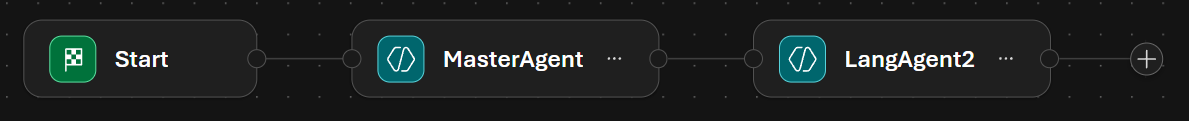

In [ ]:
import os
from azure.identity import DefaultAzureCredential
from azure.ai.projects import AIProjectClient
from azure.ai.projects.models import ResponseStreamEventType


project_client = AIProjectClient(
    endpoint="https://aifsweden.services.ai.azure.com/api/projects/AIFSwedenProject01",
    credential=DefaultAzureCredential(),
)

with project_client:

    workflow = {
        "name": "Master",
        "version": "2",
    }
    
    openai_client = project_client.get_openai_client()

    conversation = openai_client.conversations.create()
    print(f"Created conversation (id: {conversation.id})")

    stream = openai_client.responses.create(
        conversation=conversation.id,
        extra_body={"agent": {"name": workflow["name"], "type": "agent_reference"}},
        input="""Tell me ALL the PII elements from this story:

The Princess, the King, and the Dragon
In the kingdom of Eldoria, Princess Elara lived in the grand castle at 1 Royal Crescent, Eldoria City. Her official email was elara@eldoria-royals.com—a detail she guarded carefully.
King Aldric, her father, ruled from the same castle but had his own chambers and his own inbox: king.aldric@eldoria-royals.com. He often reminded Elara never to share her address with strangers.
One day, a fearsome dragon named Drakthor sent a message from drakthor@mountainfire.net, demanding tribute. The email read:

“Deliver gold to Dragons Peak, 99 Inferno Road by sunset, or face my wrath.”

Elara, clever and brave, replied:

“Dear Drakthor, your threats are noted. Expect a surprise instead.”

And so began a tale of courage, strategy, and a battle that would echo through the ages.""",
        stream=True,
        metadata={"x-ms-debug-mode-enabled": "1"},
    )

    for event in stream:
        if event.type == ResponseStreamEventType.RESPONSE_OUTPUT_TEXT_DONE:
            print("\t", event.text)
        elif event.type == ResponseStreamEventType.RESPONSE_OUTPUT_ITEM_ADDED and event.item.type == "workflow_action":
            print(f"********************************\nActor - '{event.item.action_id}' :")
        elif event.type == ResponseStreamEventType.RESPONSE_OUTPUT_ITEM_ADDED and event.item.type == "workflow_action":
            print(f"Workflow Item '{event.item.action_id}' is '{event.item.status}' - (previous item was : '{event.item.previous_action_id}')")
        elif event.type == ResponseStreamEventType.RESPONSE_OUTPUT_ITEM_DONE and event.item.type == "workflow_action":
            print(f"Workflow Item '{event.item.action_id}' is '{event.item.status}' - (previous item was: '{event.item.previous_action_id}')")
        elif event.type == ResponseStreamEventType.RESPONSE_OUTPUT_TEXT_DELTA:
            print(event.delta)
        else:
            print(f"Unknown event: {event}")

    openai_client.conversations.delete(conversation_id=conversation.id)
    print("Conversation deleted")
